# GLM Express: Subject / First-Level Demonstration

In [1]:
# You can safely ignore this cell - just for local setup
%load_ext autoreload
%autoreload 2

import os
here = os.getcwd()

if '/demo' in here:
    os.chdir('..')

In [2]:
# Imports
from glm_express import Subject
import nilearn.plotting as nip
from bids import BIDSLayout
import nibabel as nib

Hello and welcome! `GLM Express` is a lightweight package for building simple GLMs for functional neuroimaging data. Before running, consider several assumptions that this package makes:

* Your dataset is **BIDS validated**! This check is done implicitly at initialization, and the Subject object will fail if your dataset has any fatal errors

* Your dataset has been preprocessed using `fmriprep`! We assume that your raw data and events files are stored in the root of your BIDS project, and that all of your preprocessed data (confound regressors and preprocessed BOLD NifTis) are stored in a `derivatives/fmriprep` sub-directory

See below for an example dataset structure, and <a href="https://bids-specification.readthedocs.io/en/stable/" target="_blank">**see the docs**</a> for a much more verbose explanation of BIDS and its philosophy:

In [3]:
%%bash
tree ./bids_test/ -d

./bids_test/
├── derivatives
│   └── fmriprep
│       ├── sub-10159
│       │   └── func
│       ├── sub-10171
│       │   └── func
│       ├── sub-10189
│       │   └── func
│       ├── sub-10206
│       │   └── func
│       ├── sub-10217
│       │   └── func
│       ├── sub-10225
│       │   └── func
│       ├── sub-10227
│       │   └── func
│       ├── sub-10228
│       │   └── func
│       ├── sub-10235
│       │   └── func
│       └── sub-10249
│           └── func
├── sub-10159
│   ├── beh
│   └── func
├── sub-10171
│   ├── beh
│   └── func
├── sub-10189
│   ├── beh
│   └── func
├── sub-10206
│   ├── beh
│   └── func
├── sub-10217
│   ├── beh
│   └── func
├── sub-10225
│   ├── beh
│   └── func
├── sub-10227
│   ├── beh
│   └── func
├── sub-10228
│   ├── beh
│   └── func
├── sub-10235
│   ├── beh
│   └── func
└── sub-10249
    ├── beh
    └── func

52 directories


Instantiating a `BIDSLayout` object is a solid sanity check to make sure your data is BIDS-compliant (this happens under the hood in GLM Express)

In [4]:
bids = BIDSLayout('./bids_test/')

In [5]:
print(bids.get_subjects())

['10159', '10171', '10189', '10206', '10217', '10225', '10227', '10228', '10235', '10249']


-------------

## Using the glm_express.Subject object

Several parameters are required to instantiate a `Subject` object in `GLM Express`:

* `sub_id`: Subject ID, which should match the subject's label in your BIDS project
* `task`: The name of the functional task, which will match all relevant files
* `bids_root`: The top of your BIDS project (we assume that you **are not** running `GLM Express` inside your BIDS project, but rather from at least one directory level above)

In addition, there are multiple parameters with **default parameters**:

* `suppress`: Defaults to `False` | Determines if a dictionary of Subject attributes print at `__init__`
* `template_space`: Defaults to `MNI152NLin2009` | This is the template that your data was preprocessed to in `fmriprep`
* `repetition_time`: Defaults to `1.` | The TR from you functional run
* `dummy_scans`: Defaults to `0` | Any non-steady state volumes detected by `fmriprep`; these can be updated programatically before creating your design matrix

The `Subject` object also creates a output directory when instantiated - this is where all of your contrast maps, plots and other data derived from your first level models will be stored

In [6]:
# Instantiate your Subject object
subject = Subject('10159', task='stopsignal', bids_root='./bids_test/')

{
    "Subject ID": "10159",
    "Task": "stopsignal",
    "# of Functional Runs": 1,
    "Output Directory": "./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal",
    "Defined Contrasts": "default",
    "Confound Regressors": [
        "GlobalSignal",
        "FramewiseDisplacement",
        "WhiteMatter",
        "stdDVARS"
    ]
}


In [7]:
subject.first_level_output

'./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal'

--------

### Subject Attributes

As we noted above, the `Subject` object defaults to several parameters but these can be easily overridden with the built-in `set_{ }` functions

In [8]:
subject.template_space

'MNI152NLin2009'

In [9]:
subject.set_template_space('MNI152Lin6')
subject.template_space

'MNI152Lin6'

In [10]:
subject.dummy_scans

0

In [11]:
subject.set_dummy_scans(2)
subject.dummy_scans

2

In [12]:
subject.t_r

1.0

In [13]:
subject.set_tr(2.)
subject.t_r

2.0

The `Subject` object also creates a `bids_container` attribute - this is a dictionary with keys per functional run AND keys per data type (e.g., functional, events, confounds)

In [14]:
subject.bids_container

{'run-1': {'func': './bids_test/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
  'event': './bids_test/sub-10159/func/sub-10159_task-stopsignal_events.tsv',
  'confound': './bids_test/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_confounds.tsv'},
 'all_func': ['./bids_test/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'],
 'all_events': ['./bids_test/sub-10159/func/sub-10159_task-stopsignal_events.tsv'],
 'all_confounds': ['./bids_test/derivatives/fmriprep/sub-10159/func/sub-10159_task-stopsignal_bold_confounds.tsv']}

This dictionary is also saved locally to the current subject's output directory in a JSON file

In [15]:
os.listdir(subject.first_level_output)

['models', 'plots', 'sub-10159_task-stopsignal_bids-container.json']

------

### Building a Model

To build a simple GLM, we need the **preprocessed NifTi files** and a **design matrix corresponding to each functional run** ... `GLM Express` is optimized to accept run arguments, but defaults to **"ALL"**, which gives you an aggregated DataFrame of either events or confounds

In [16]:
# We'll start with a fresh Subject to model with
subject = Subject('10159', task='stopsignal', bids_root='./bids_test/')

{
    "Subject ID": "10159",
    "Task": "stopsignal",
    "# of Functional Runs": 1,
    "Output Directory": "./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal",
    "Defined Contrasts": "default",
    "Confound Regressors": [
        "GlobalSignal",
        "FramewiseDisplacement",
        "WhiteMatter",
        "stdDVARS"
    ]
}


In [17]:
subject.load_events(run=1)

,onset,duration,trial_type,PresentedStimulusArrowDirection,ReactionTime,SubjectResponseButton,SubjectResponseButtonCode,SubjectResponseCorrectness,TrialOutcome,StopSignalDelay,LadderNumber,LadderTime,LadderMovement,TimeCourse,onset_noTriggerAdjust,TimeCourse_noTriggerAdjust,run
0,0.006134,1.500,GO,LEFT,0.416274,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,0.000,0.006134,0.000,1
1,0.000000,2.250,NaN,BLANKSCREEN,0.000000,NaN,0,NaN,NaN,0.0,0,0,0,1.500,0.000000,1.500,1
2,3.762595,1.500,GO,RIGHT,0.395370,RIGHT,28,CorrectResponse,SuccessfulGo,0.0,0,0,0,3.750,3.762595,3.750,1
3,0.000000,0.750,NaN,BLANKSCREEN,0.000000,NaN,0,NaN,NaN,0.0,0,0,0,5.250,0.000000,5.250,1
4,6.013056,1.500,GO,LEFT,0.397906,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,6.000,6.013056,6.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.000000,0.500,NaN,BLANKSCREEN,0.000000,NaN,0,NaN,NaN,0.0,0,0,0,347.375,0.000000,347.375,1
252,347.888159,1.500,GO,LEFT,0.515824,LEFT,5,CorrectResponse,SuccessfulGo,0.0,0,0,0,347.875,347.888159,347.875,1
253,0.000000,1.500,NaN,BLANKSCREEN,0.000000,NaN,0,NaN,NaN,0.0,0,0,0,349.375,0.000000,349.375,1
254,350.883213,1.500,GO,RIGHT,0.383631,RIGHT,28,CorrectResponse,SuccessfulGo,0.0,0,0,0,350.875,350.883213,350.875,1


In [18]:
subject.load_confounds(run=1)

,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,tCompCor03,...,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ,run
0,-0.899719,2.227516,NaN,NaN,NaN,NaN,-0.118771,0.113172,-0.032137,0.041810,...,0.018290,-0.106118,0.188625,0.143525,-0.052645,-0.274967,0.001024,0.001434,0.000467,1
1,-1.246341,0.326954,1.090498,24.634428,1.026863,0.099904,-0.181387,0.036984,0.113388,0.048676,...,0.058030,-0.015722,0.111118,0.163622,-0.028109,-0.263217,0.000837,0.002068,0.000516,1
2,0.366020,-1.068786,1.151430,26.010887,1.027507,0.252018,-0.046286,-0.033369,-0.076722,0.032938,...,-0.052342,-0.031574,-0.061752,0.118415,-0.006555,-0.167094,0.001868,0.001368,0.000464,1
3,-0.564770,-1.443347,1.106344,24.992373,0.920317,0.122212,-0.043669,-0.053250,-0.036809,-0.024905,...,0.010522,-0.061436,0.018885,0.096408,-0.006393,-0.137269,0.000894,0.000948,0.000454,1
4,-1.436600,-3.153236,0.914109,20.649788,0.871629,0.014257,-0.074981,-0.079292,0.079099,-0.054966,...,0.063985,-0.049137,0.070348,0.102231,-0.006412,-0.136650,0.001024,0.000948,0.000429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.513565,-0.389184,1.118991,25.278082,0.983155,0.183595,-0.089380,0.077009,0.035236,-0.036337,...,0.146618,0.032852,0.061648,-0.239208,0.295401,-0.695440,0.015381,0.000187,-0.008214,1
180,-0.904468,-4.511670,1.011077,22.840292,0.980504,0.085425,-0.113513,-0.016334,0.127348,-0.157195,...,0.196972,-0.086517,0.093522,-0.239296,0.272096,-0.659105,0.015512,0.000204,-0.008579,1
181,-1.420769,-6.542420,0.993432,22.441696,0.958697,0.226487,-0.108002,-0.102629,0.051931,-0.220408,...,0.158629,-0.156444,-0.031886,-0.222895,0.271756,-0.580863,0.014104,0.000714,-0.009290,1
182,-1.746273,-5.993458,1.013192,22.888075,0.931125,0.086695,-0.099087,-0.080652,-0.075379,-0.196365,...,0.161150,-0.022039,-0.135137,-0.239418,0.252843,-0.598063,0.014242,0.000242,-0.009219,1


Likewise, the `generate_design_matrix` function takes a `run` argument as well ... for each functional run, this function aggregates relevant columns from the events file and your selected confounds (defined externally in the `task_information.json` file)

<AxesSubplot:label='conditions', ylabel='scan number'>

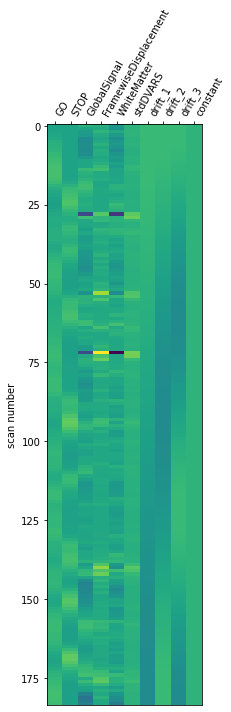

In [19]:
nip.plot_design_matrix(subject.generate_design_matrix(run=1))

The confounds below were selected for demonstrative purposes, but can be overriden by either:

* Updating the `task_information.json` file manually, or
* Updating the `Subject` attributes using `set_confound_regressors`

In [20]:
subject.confound_regressors

['GlobalSignal', 'FramewiseDisplacement', 'WhiteMatter', 'stdDVARS']

In [21]:
subject.set_confound_regressors([])

<AxesSubplot:label='conditions', ylabel='scan number'>

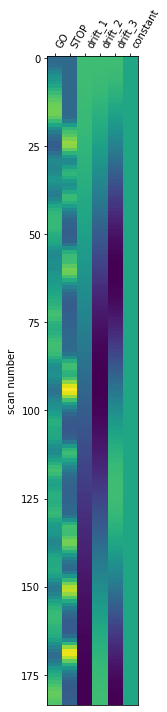

In [22]:
nip.plot_design_matrix(subject.generate_design_matrix(run=1))

The contrasts for each task are `'default'` when the `task_information.json` file is created ... you can either update the file with a dictionary of contrasts, or feed your `Subject` a dictionary of contrasts

In either case, you should follow `{contrast_name: column1 - column2}` format

In [23]:
subject.contrasts

'default'

In [24]:
subject.set_design_contrasts({'new_contrast':'STOP - GO'})

In [25]:
subject.contrasts

{'new_contrast': 'STOP - GO'}

Your subject's first level output directory is empty by default:

In [26]:
%%bash
tree ./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/

./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/
├── models
│   ├── condition-maps
│   └── contrast-maps
├── plots
│   ├── condition-maps
│   └── contrast-maps
└── sub-10159_task-stopsignal_bids-container.json

6 directories, 1 file


Calling the `run_first_level_glm` function will create design matrices for each functional run, and fit a model to your specifications:

In [27]:
subject.run_first_level_glm()


            

Running first-level designs for STOPSIGNAL with the following parameters:



            Non-steady state regressors:	False

            Modulators:				False

            Auto-block regressors:		False

            Motion outliers:			True

            Fixation trials:			True
            


            

=== Fitting GLM ===


  0%|          | 0/2 [00:00<?, ?it/s]


=== Mapping condition z-scores ===



  0%|          | 0/1 [00:00<?, ?it/s]


=== Mapping contrast z-scores ===



100%|██████████| 1/1 [00:05<00:00,  5.69s/it]



=== STOPSIGNAL contrasts computed! Subject 10159 has been mapped ===




All contrast maps, plots, and summary data files have been successfully stored in your subject's first level output directory:

In [28]:
%%bash
tree ./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/

./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/
├── models
│   ├── condition-maps
│   │   ├── sub-10159_condition-GO_smoothing-8mm_z-map.nii.gz
│   │   └── sub-10159_condition-STOP_smoothing-8mm_z-map.nii.gz
│   └── contrast-maps
│       └── sub-10159_contrast-new_contrast_smoothing-8mm_z-map.nii.gz
├── plots
│   ├── condition-maps
│   │   ├── sub-10159_condition-GO_smoothing-8mm_contrast-summary.html
│   │   ├── sub-10159_condition-GO_smoothing-8mm_plot-stat-map.png
│   │   ├── sub-10159_condition-STOP_smoothing-8mm_contrast-summary.html
│   │   └── sub-10159_condition-STOP_smoothing-8mm_plot-stat-map.png
│   ├── contrast-maps
│   │   ├── sub-10159_contrast-new_contrast_smoothing-8mm_contrast-summary.html
│   │   └── sub-10159_contrast-new_contrast_smoothing-8mm_plot-stat-map.png
│   └── sub-10159_task-stopsignal_run-1_design-matrix.jpg
└── sub-10159_task-stopsignal_bids-container.json

6 directories, 11 files


The `smoothing` parameter defaults to `8.`, but can be updated as you see fit. This also updates the naming conventions for all output files, so you don't have to worry about files being overwritten:

In [29]:
subject.run_first_level_glm(smoothing=4.)


            

Running first-level designs for STOPSIGNAL with the following parameters:



            Non-steady state regressors:	False

            Modulators:				False

            Auto-block regressors:		False

            Motion outliers:			True

            Fixation trials:			True
            


            

=== Fitting GLM ===


  0%|          | 0/2 [00:00<?, ?it/s]


=== Mapping condition z-scores ===



  0%|          | 0/1 [00:00<?, ?it/s]


=== Mapping contrast z-scores ===



100%|██████████| 1/1 [00:06<00:00,  6.84s/it]



=== STOPSIGNAL contrasts computed! Subject 10159 has been mapped ===




In [30]:
%%bash
tree ./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/

./bids_test/derivatives/first-level-output/sub-10159/task-stopsignal/
├── models
│   ├── condition-maps
│   │   ├── sub-10159_condition-GO_smoothing-4mm_z-map.nii.gz
│   │   ├── sub-10159_condition-GO_smoothing-8mm_z-map.nii.gz
│   │   ├── sub-10159_condition-STOP_smoothing-4mm_z-map.nii.gz
│   │   └── sub-10159_condition-STOP_smoothing-8mm_z-map.nii.gz
│   └── contrast-maps
│       ├── sub-10159_contrast-new_contrast_smoothing-4mm_z-map.nii.gz
│       └── sub-10159_contrast-new_contrast_smoothing-8mm_z-map.nii.gz
├── plots
│   ├── condition-maps
│   │   ├── sub-10159_condition-GO_smoothing-4mm_contrast-summary.html
│   │   ├── sub-10159_condition-GO_smoothing-4mm_plot-stat-map.png
│   │   ├── sub-10159_condition-GO_smoothing-8mm_contrast-summary.html
│   │   ├── sub-10159_condition-GO_smoothing-8mm_plot-stat-map.png
│   │   ├── sub-10159_condition-STOP_smoothing-4mm_contrast-summary.html
│   │   ├── sub-10159_condition-STOP_smoothing-4mm_plot-stat-map.png
│   │   ├── sub-10159_conditi

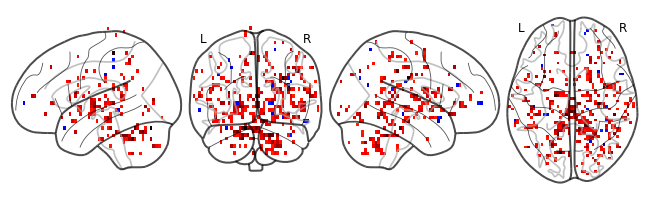

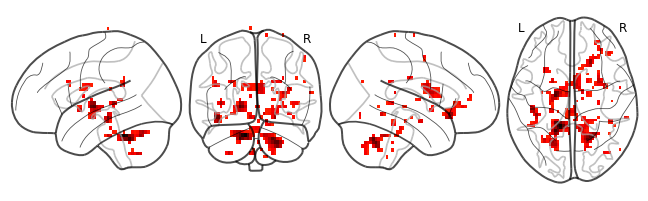

In [31]:
contrast_dirs = os.path.join(subject.first_level_output, 'models/contrast-maps')
contrasts = [os.path.join(contrast_dirs, x) for x in os.listdir(contrast_dirs)]

for file in contrasts:
    nip.plot_glass_brain(file, threshold=2.8, plot_abs=False, display_mode='lyrz')

C'est voila! Two different smoothing kernels have been successfully applied to the data, and now we can repeat for all subjects in our BIDS Project. Happy modeling!

----------